In [36]:
import sys
sys.path.append("../src/phloemfinder/")

import matplotlib

import numpy as np
import pandas as pd

from utils import median_of_ratios_normalisation, compute_metrics_classification, calculate_percentile, extract_samples_to_condition

from metabolome_analysis import MetaboliteAnalysis
from feature_selection_using_ml import MetabolitePhenotypeFeatureSelection

from autosklearn.classification import AutoSklearnClassifier
from autosklearn.metrics import balanced_accuracy, precision, recall, f1
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score

In [37]:
met = MetaboliteAnalysis(
    metabolome_csv="../../nymph_development_screen/01_data/phloem_data/20221220_complete_set_phloem_negative_ready_for_filtering.csv", 
    metabolome_feature_id_col="feature_id")

In [38]:
met.validate_input_metabolome_df()
met.metabolome.shape

Metabolome input data validated.


(10966, 73)

In [39]:
print("Number of total features before blank filtering = {0}".format(met.metabolome.shape[0]))

Number of total features before blank filtering = 10966


# Filter out features (filters blank, unreliable features)

## Blank filtering

In [40]:
met.discard_features_detected_in_blanks(blank_sample_contains="blank")
print("Number of total features after blank filtering = {0}".format(met.metabolome.shape[0]))

Number of total features after blank filtering = 7512


## PCA before normalisation

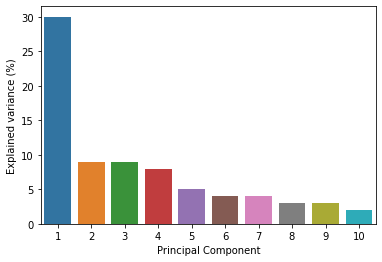

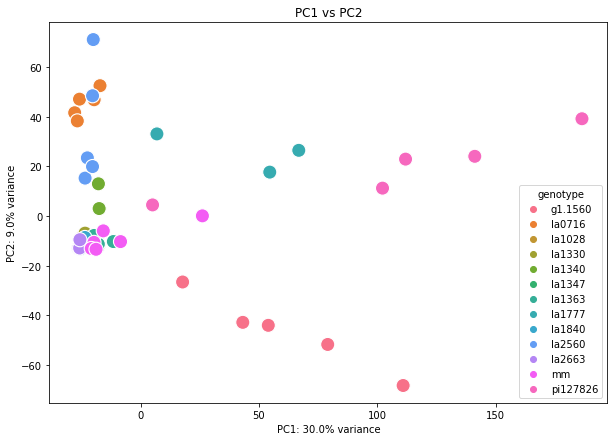

In [41]:
met.compute_pca_on_metabolites()
met.create_scree_plot()
met.create_sample_score_plot()

## PCA after normalisation

/Users/mgalland/opt/miniconda3/envs/sklearn/lib/python3.9/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


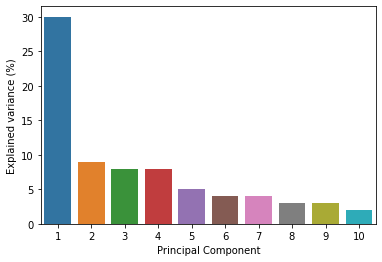

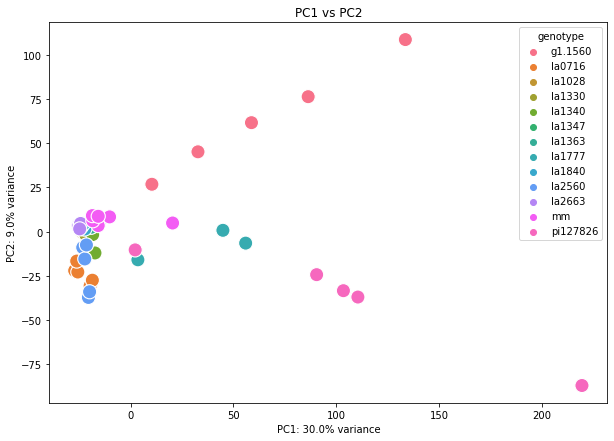

In [42]:
met.normalise_values_by_median_of_ratios_method()
met.compute_pca_on_metabolites()
met.create_scree_plot()
met.create_sample_score_plot()

## Density plots per group

## Filter by percentile

In [43]:
met.metabolome.shape

(7512, 60)

In [44]:
met.filter_features_per_group_by_percentile(percentile=95)

In [45]:
met.compute_metabolome_sparsity()

Sparsity of the metabolome matrix is equal to 58.880 %


## Unreliable feature filtering

In [46]:
met.filter_out_unreliable_features(nb_times_detected=4)

In [47]:
met.metabolome.shape

(3182, 60)

In [48]:
met.compute_metabolome_sparsity()

Sparsity of the metabolome matrix is equal to 53.433 %


In [49]:
met.write_clean_metabolome_to_csv(path_of_cleaned_csv="../tests/clean_metabolome.csv")

# Feature selection

In [50]:
fs = MetabolitePhenotypeFeatureSelection(
    metabolome_csv="../tests/clean_metabolome.csv", 
    phenotype_csv="../sample_datasets/phenotypes_test_data_negative.csv", 
    phenotype_sample_id='sample')

In [51]:
fs.validate_input_metabolome_df()

Metabolome data validated.


In [52]:
fs.validate_input_phenotype_df()

Phenotype data validated.


## Base performance

In [53]:
fs.get_baseline_performance(
    class_of_interest='resistant',
    train_size=0.7, 
    random_state=1234)

====== Training a basic Random Forest model =======
Average balanced_accuracy score on training data is: 86.800 % -/+ 13.50


====== Performance on test data of the basic Random Forest model =======
Average balanced_accuracy score on test data is: 88.300 %


## TPOT best model from the class

In [54]:
fs.search_best_model_with_tpot_and_get_feature_importances(
    class_of_interest='resistant', 
    train_size=0.7,
    max_time_mins=2,
    max_eval_time_mins=1, 
    random_state=1234)

============ Performance of ML model on train data =============
Train balanced_accuracy score 88.100 %


============ Performance of ML model on test data =============
                   value
balanced_accuracy  0.669
precision          0.750
recall             0.429
f1 score           0.545


======== Computing feature importances on the training set =======


In [55]:
X = fs.metabolome.transpose().to_numpy(dtype='float64')
y = fs.phenotype.values.ravel()
print(X.shape)
print(y.shape)

(60, 3182)
(60,)


In [65]:
import numpy as np

# define matrix
mat = np.array([[8, 2, 3, 4, 5],
                [9, 5, 3, 8, 1],
                [2, 4, 5, 7, 6],
                [3, 4, 6, 8, 5],
                [4, 5, 3, 9]])

/var/folders/n8/6bs0rvd563j2nvq3xjrpv6400000gn/T/ipykernel_79595/3828776764.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  mat = np.array([[8, 2, 3, 4, 5],


In [89]:
loadings = np.array([[2, 1, 3, 5, 4, 6], [1, 2, 7, 4, 5, 6]], np.int32)
loadings

array([[2, 1, 3, 5, 4, 6],
       [1, 2, 7, 4, 5, 6]], dtype=int32)

In [87]:
selected_pc = 1 
zero_off_selected_pc = selected_pc - 1
assert selected_pc > 0, "Please select a PC equal or higher than 1" 
loadings_of_selected_pc = loadings[selected_pc]
loadings_of_selected_pc

array([4, 5, 6], dtype=int32)

In [88]:
top_n_loadings_of_selected_pc = 3 # choose a number of top loadings to return 
sorted_loadings_of_selected_pc = np.argsort(loadings_of_selected_pc)[::-1][] # argsort returns the indices
sorted_loadings_of_selected_pc

array([6, 5, 4], dtype=int32)